# Logistic testing

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from copy import deepcopy
from sklearn.datasets import make_regression as Make_reg # default is 100 samples, 100 features
from sklearn.datasets import make_classification as Make_class # default is 100 samples, 20 features, 2 classes
from sklearn.model_selection import train_test_split as split

$h(w)$: Sigmoid function:

$$\frac{1}{1 + e^{-\langle x, w \rangle}}$$

$f_{\text{LOG}}(w)$: negative log liklihood function:

$$-\frac{1}{k}  \sum_{i=1}^k \bigg( y_k \log(h(w)) + (1 - y_k) \log(1 -h(w))\bigg) $$

Explicitly:

$$\frac{1}{k} \sum_{i=1}^k \Bigg( -y_k \log\bigg(\frac{1}{1 + e^{-\langle x_k, w \rangle}}\bigg) - (1 - y_k) \log\bigg(1 - \frac{1}{1 + e^{-\langle x_k, w \rangle}}\bigg) \Bigg)$$

$g_{\text{LOG}}(w) = f'_{\text{LOG}}(w)$: gradient function of negative log liklihood:

$$ \langle h(w) - y, x \rangle $$

Explicitly:

$$ \Bigg\langle \frac{1}{1 + e^{-\langle x, w \rangle}} - y, x \Bigg\rangle = \frac{1}{k} \sum_{i=1}^k  x_k \Bigg( \frac{1}{1 + e^{-\langle x_k, w \rangle}} - y_k \Bigg) $$

A note on the data:

$x$ is an $m \times n$ matrix of $m$ samples and $n$ features. So it is a dataset in $\mathbb{R}^n$.

$y$ is a $m \times 1$ vector with a binary classifier for each sample.

$w$ is a $1 \times n$ array.

### Defining Functions

In [69]:
def ren(x): return range(len(x)) # a function for plotting iterates of a list
def sigmoid(w, x): # a basic sigmoid function
    denom = 1 + np.exp( - np.dot(x,w) )
    return 1 / denom
def normalise(x): # normalises the input data to values between 0 and 1
    mins = np.min(x, axis = 0)
    maxs = np.max(x, axis = 0)
    rng = maxs - mins
    return  1 - (maxs- x)/rng
def f_Log(w, x, y): # neg log likli func: see LaTeX above
    sig = sigmoid(w,x)
    step1 = y*np.log(sig + 1e-300)
    step2 = (1-y)*np.log(1 - sig + 1e-300)
    return np.mean(-step1 - step2)
def g_Log(w, x, y): # simplified gradient function, essentially just x(h(w) - y): see LaTeX above
    sig = sigmoid(w,x)
    inner = sig - y
    return np.dot(inner, x)
def GD_Log(w, lam, x, y):
    return w - lam*g_Log(w,x,y)
def predict(w, x):
    sig = sigmoid(w, x)
    return np.squeeze( np.where(sig >= 0.5, 1, 0) )
def classify(w, x_Te, y_Te):
    return sum( predict(w, x_Te) == y_Te ) / len(x_Te)

### Make classification dataset

In [99]:
my_classes = Make_class(n_samples=1000)
ones_array = np.array([[1]*len(my_classes[0])])
aug_data = np.concatenate((ones_array.T, normalise(my_classes[0])), axis = 1)
xTrain, xTest, yTrain, yTest = split( aug_data, my_classes[1], test_size = 0.1)
w_copy = np.random.rand(len(xTrain[0]))

## Vanilla Gradient Descent

Time limit of 30 seconds

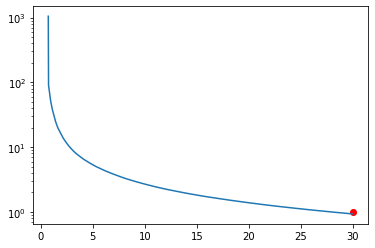

In [108]:
error = 1e-2
initialTime = time.time()
w = w_copy
lam = 1/np.max( np.linalg.svd(xTrain @ xTrain.T)[1] )
grad = g_Log(w, xTrain, yTrain)
gradNorm = np.linalg.norm(grad)
gradientValList = [gradNorm]
functionValList = [f_Log(w, xTrain, yTrain)]
timeList = [time.time() - initialTime]
predList = [classify(w, xTest, yTest)]
while gradNorm > error:
    w = GD_Log(w, lam, xTrain, yTrain)
    grad = g_Log(w, xTrain, yTrain)
    gradNorm = np.linalg.norm(grad)
    gradientValList.append(gradNorm)
    functionValList.append(f_Log(w, xTrain, yTrain))
    timeList.append(time.time() - initialTime)
    predList.append(classify(w,xTest,yTest))
    if timeList[-1] > 30:
        break
plt.scatter(timeList[- (np.argmax(predList[::-1])+1)], gradientValList[- (np.argmax(predList[::-1])+1)], c= 'r')
plt.plot(timeList, gradientValList)
plt.yscale('log')
plt.show()

## Adaptive Gradient Descent

Time limit of 30 seconds

<ipython-input-69-403024de6bf8>:3: RuntimeWarning: overflow encountered in exp
  denom = 1 + np.exp( - np.dot(x,w) )
<ipython-input-119-334ff27cfb41>:21: RuntimeWarning: divide by zero encountered in double_scalars
  lam = np.min([ min1, min2a/min2b ])


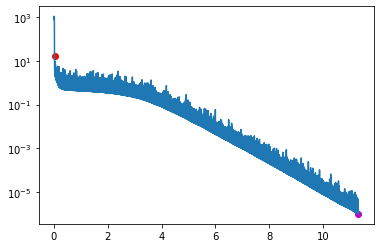

In [119]:
error = 1e-6
initialTime = time.time()
w = w_copy
w0 = w
lam = random.random()+1e-12
lam0 = lam
theta = np.inf
grad = g_Log(w, xTrain, yTrain)
grad0 = grad
gradNorm = np.linalg.norm(grad)
gradientValList = [gradNorm]
functionValList = [f_Log(w, xTrain, yTrain)]
timeList = [time.time() - initialTime]
predList = [classify(w, xTest, yTest)]
w = GD_Log(w, lam, xTrain, yTrain)
grad = g_Log(w, xTrain, yTrain)
while gradNorm > error:
    min1 = np.sqrt(1 + theta)*lam
    min2a = np.linalg.norm( w - w0)
    min2b = 2*np.linalg.norm( grad - grad0 )
    lam = np.min([ min1, min2a/min2b ])
    w0 = w
    grad0 = grad
    w = GD_Log(w,lam,xTrain,yTrain)
    theta = lam / lam0
    lam0 = lam
    grad = g_Log(w, xTrain, yTrain)
    gradNorm = np.linalg.norm(grad)
    gradientValList.append(gradNorm)
    functionValList.append(f_Log(w, xTrain, yTrain))
    timeList.append(time.time() - initialTime)
    predList.append(classify(w,xTest,yTest))
    if timeList[-1] > 30:
        break

plt.scatter(timeList[np.argmax(predList)], gradientValList[np.argmax(predList)], c= 'r')
plt.scatter(timeList[- (np.argmax(predList[::-1])+1)], gradientValList[- (np.argmax(predList[::-1])+1)], c= 'm')
plt.plot(timeList, gradientValList)
plt.yscale('log')
plt.show()

In [113]:
print(np.max(predList))
print(predList[-1])

0.99
0.98


## Gradient Line Search Gradient Descent

<ipython-input-69-403024de6bf8>:3: RuntimeWarning: overflow encountered in exp
  denom = 1 + np.exp( - np.dot(x,w) )


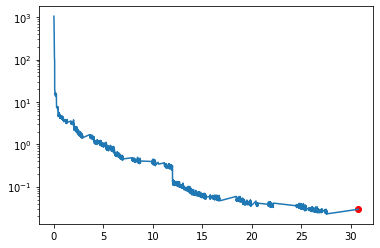

In [118]:
def BackTrack(w,x,y,grad):
    rho = random.random()
    lam = random.randrange(1e6)
    while lam > ( np.linalg.norm(lam * grad) / np.linalg.norm( g_Log(w - lam*grad, x, y) - grad )):
        lam = rho*lam
    return lam

error = 1e-2
initialTime = time.time()
w = w_copy
grad = g_Log(w, xTrain, yTrain)
gradNorm = np.linalg.norm(grad)
gradientValList = [gradNorm]
functionValList = [f_Log(w, xTrain, yTrain)]
timeList = [time.time() - initialTime]
predList = [classify(w, xTest, yTest)]
while gradNorm > error:
    lam = BackTrack(w, xTrain, yTrain, grad)
    w = GD_Log(w, lam, xTrain, yTrain)
    grad = g_Log(w, xTrain, yTrain)
    gradNorm = np.linalg.norm(grad)
    gradientValList.append(gradNorm)
    functionValList.append(f_Log(w, xTrain, yTrain))
    timeList.append(time.time() - initialTime)
    predList.append(classify(w,xTest,yTest))
    if timeList[-1] > 30:
        break
plt.scatter(timeList[- (np.argmax(predList[::-1])+1)], gradientValList[- (np.argmax(predList[::-1])+1)], c= 'r')
plt.plot(timeList, gradientValList)
plt.yscale('log')
plt.show()

before [-459.         -232.50640282 -258.70035843 -204.66508268 -218.51874829
 -220.97281317 -177.15550704 -215.74174671 -241.46157705 -218.35098488
 -318.39269361 -247.75028506 -238.6997652  -210.53874313 -233.85990458
 -257.29123777 -228.23265289 -204.41599223 -214.28462541 -230.78553086
 -208.3798006 ]
0.05086970900291051
after [-459.         -232.50640282 -258.70035843 -204.66508268 -218.51874829
 -220.97281317 -177.15550704 -215.74174671 -241.46157705 -218.35098488
 -318.39269361 -247.75028506 -238.6997652  -210.53874313 -233.85990458
 -257.29123777 -228.23265289 -204.41599223 -214.28462541 -230.78553086
 -208.3798006 ]
before [-459.         -232.50640282 -258.70035843 -204.66508268 -218.51874829
 -220.97281317 -177.15550704 -215.74174671 -241.46157705 -218.35098488
 -318.39269361 -247.75028506 -238.6997652  -210.53874313 -233.85990458
 -257.29123777 -228.23265289 -204.41599223 -214.28462541 -230.78553086
 -208.3798006 ]
nan
after [nan nan nan nan nan nan nan nan nan nan nan nan n

<ipython-input-150-359bb2915de9>:18: RuntimeWarning: invalid value encountered in double_scalars
  lam = nom/denom


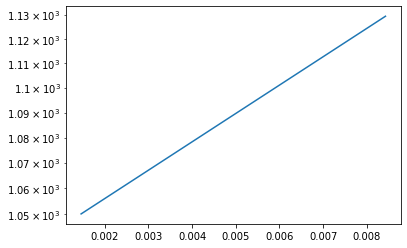

In [150]:
error = 1e-2
initialTime = time.time()
w = w_copy
lam = random.random()+1e-12
w0 = w
grad = g_Log(w, xTrain, yTrain)
grad0 = deepcopy(grad)
gradNorm = np.linalg.norm(grad)
gradientValList = [gradNorm]
functionValList = [f_Log(w, xTrain, yTrain)]
timeList = [time.time() - initialTime]
predList = [classify(w, xTest, yTest)]
w = GD_Log(w, lam, xTrain, yTrain)
grad = g_Log(w, xTrain, yTrain)
while gradNorm > error:
    nom = np.dot(w - w0, grad - grad0 )
    denom = np.linalg.norm( grad - grad0 )**2
    lam = nom/denom
    w0 = w
    grad0 = deepcopy(grad)
    print("before", g_Log(w, xTrain, yTrain))
    print(lam)
    w = GD_Log(w, lam, xTrain, yTrain)
    print("after", g_Log(w, xTrain, yTrain))
    grad = g_Log(w, xTrain, yTrain)
    gradNorm = np.linalg.norm(grad)
    gradientValList.append(gradNorm)
    functionValList.append(f_Log(w, xTrain, yTrain))
    timeList.append(time.time() - initialTime)
    predList.append(classify(w,xTest,yTest))
    if timeList[-1] > 30:
        break
plt.scatter(timeList[- (np.argmax(predList[::-1])+1)], gradientValList[- (np.argmax(predList[::-1])+1)], c= 'r')
plt.plot(timeList, gradientValList)
plt.yscale('log')
plt.show()

In [140]:
predList

[0.42, 0.58, 0.58]